In [8]:
import pandas as pd
import dtaidistance.dtw_ndim
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import dtaidistance
from dtaidistance import dtw_ndim
from dtaidistance import dtw_visualisation
from dtaidistance import dtw_ndim_visualisation
import numpy as np
import matplotlib.pyplot as plt
import time
from random import randint
from tqdm import tqdm_notebook
%matplotlib inline

In [9]:
def MDTW_L2_dist(v1, v2, window=None):
    return dtaidistance.dtw_ndim.distance(v1, v2, window=window)

def MDTW_L2_path(matr):
    return dtaidistance.dtw.best_path(matr)

def MDTW_L2_matr(v1, v2):
    return dtaidistance.dtw_ndim.warping_paths(v1, v2)

def MDTW_L2_visualisation(v1, v2, path):
    # another way to visualise
    # dtaidistance.dtw_ndim_visualisation.plot_warping(v1, v2, path)
    for i in range(v1.shape[1]):
        dtaidistance.dtw_visualisation.plot_warping(v1[:, i], v2[:, i], path)
        
#def prepare_data(data):
#    return data.reshape(data.shape[0], data.shape[1] * data.shape[2])

#def MDTW_L2_dist_1d(v1, v2):
#    return data.reshape()

In [10]:
def MDTW_DTW_dist(v1, v2, metric=dtaidistance.dtw.distance, window=None):
    n = len(v1)
    m = len(v2)
    dp = np.zeros((n + 1, m + 1))
    dp[0][0] = 0
    for i in range(1, n + 1):
        dp[i][0] = np.inf
    for i in range(1, m + 1):
        dp[0][i] = np.inf
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if window is None or abs(i - j) < window:
                dp[i][j] = metric(v1[i - 1], v2[j - 1]) ** 2 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])
            elif abs(i - j) == window:
                if i - j == window:
                    dp[i][j] = metric(v1[i - 1], v2[j - 1]) ** 2 + min(dp[i - 1][j], dp[i - 1][j - 1])
                else:
                    dp[i][j] = metric(v1[i - 1], v2[j - 1]) ** 2 + min(dp[i][j - 1], dp[i - 1][j - 1])
            else:
                dp[i][j] = np.inf
                
    return dp[n][m] ** 0.5

In [11]:
def MDTW_DTW_matr(v1, v2, metric=dtaidistance.dtw.distance, window=None):
    n = len(v1)
    m = len(v2)
    dp = np.zeros((n + 1, m + 1))
    dp[0][0] = 0
    for i in range(1, n + 1):
        dp[i][0] = np.inf
    for i in range(1, m + 1):
        dp[0][i] = np.inf
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if window is None or abs(i - j) < window:
                dp[i][j] = metric(v1[i - 1], v2[j - 1]) ** 2 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])
            elif abs(i - j) == window:
                if i - j == window:
                    dp[i][j] = metric(v1[i - 1], v2[j - 1]) ** 2 + min(dp[i - 1][j], dp[i - 1][j - 1])
                else:
                    dp[i][j] = metric(v1[i - 1], v2[j - 1]) ** 2 + min(dp[i][j - 1], dp[i - 1][j - 1])
            else:
                dp[i][j] = np.inf
    return dp ** 0.5
   
    
def MDTW_DTW_path(v1, v2, matr):
    time_path = dtaidistance.dtw.best_path(matr)
    signal_path = []
    for el in time_path:
        matr = MDTW_L2_matr(v1[el[0]], v2[el[1]])[1]
        signal_path.append(dtaidistance.dtw.best_path(matr))
    return (time_path, signal_path)


def MDTW_DTW_visualisation(v1, v2, path):
    time_path, signal_path = path
    for i in range(len(time_path)):
        print('1 time series signal ' + str(time_path[i][0]) + '\n' +
                  '2 time series signal ' + str(time_path[i][1]))
        dtaidistance.dtw_visualisation.plot_warping(v1[time_path[i][0]], v2[time_path[i][1]], signal_path[i])
        plt.show()

In [12]:
def prepare_data(data):
    return data.reshape(data.shape[0], data.shape[1] * data.shape[2])

    
def prepared_L2(left, right):
    #print(left.shape, right.shape)
    return MDTW_L2_dist(left.reshape(dim, left.shape[0] // dim),
                        right.reshape(dim, right.shape[0] // dim))


def prepared_DTW(left, right):
    return MDTW_DTW_dist(left.reshape(dim, left.shape[0] // dim),
                        right.reshape(dim, right.shape[0] // dim))

In [13]:
class Experiment:
    def __init__(self, data, labels, eps=1e-9):
        self.data = data
        self.labels = labels
        self.eps = 1e-9
    
    def calc_dist_experiment(self, idx1, idx2):
        print(idx1, idx2, MDTW_L2_dist(self.data[idx1], self.data[idx2]) ** 2)
        print(idx1, idx2, MDTW_DTW_dist(self.data[idx1], self.data[idx2]) ** 2)
        
    def description_dist(self):
        equals = 0
        less = 0
        greater = 0
        max_diff = 0
        mean_diff = 0
        max_idx1 = 0
        max_idx2 = 0
        for idx1 in tqdm_notebook(range(len(self.data))):
            for idx2 in tqdm_notebook(range(len(self.data))):
                dst1 = MDTW_L2_dist(self.data[idx1], self.data[idx2])
                dst2 = MDTW_DTW_dist(self.data[idx1], self.data[idx2])
                if dst1 == dst2 or abs(dst1 - dst2) < self.eps:
                    equals += 1
                elif dst1 < dst2:
                    less += 1
                else:
                    greater += 1
                if dst1 - dst2 > max_diff:
                    max_diff = dst1 - dst2
                    max_idx1 = idx1
                    max_idx2 = idx2
                mean_diff += dst1 - dst2
        mean_diff /= len(data) * len(data)
        print('Calculate distance experiment results:')
        print('L2 = DTW', equals)
        print('L2 < DTW', less)
        print('L2 > DTW', greater)
        print('Maximum difference between L2 and DTW:', max_diff)
        print('Indexes of maximum difference:', max_idx1, max_idx2)
        print('Mean value of difference:', mean_diff)
        
    def time_experiment(self, iter_count=100, cnt_signals=None, info=True):
        if cnt_signals is None:
            cnt_signals = self.data.shape[1]
        L2_time = {'min': np.inf, 'max': 0, 'mean': 0}
        DTW_time = {'min': np.inf, 'max': 0, 'mean': 0}
        for i in range(iter_count):
            idx1 = randint(0, len(self.data) - 1)
            idx2 = randint(0, len(self.data) - 1)
            begin = time.time()
            MDTW_L2_dist(self.data[idx1][:cnt_signals], self.data[idx2][:cnt_signals])
            end = time.time()
            L2_time['min'] = min(L2_time['min'], end - begin)
            L2_time['max'] = max(L2_time['max'], end - begin)
            L2_time['mean'] += (end - begin) / iter_count
            
            begin = time.time()
            MDTW_DTW_dist(self.data[idx1][:cnt_signals], self.data[idx2][:cnt_signals])
            end = time.time()
            DTW_time['min'] = min(DTW_time['min'], end - begin)
            DTW_time['max'] = max(DTW_time['max'], end - begin)
            DTW_time['mean'] += (end - begin) / iter_count
            
        if info:
            print('L2 time result:')
            print('min:', L2_time['min'])
            print('max:', L2_time['max'])
            print('mean:', L2_time['mean'])
        
            print('DTW time result:')
            print('min:', DTW_time['min'])
            print('max:', DTW_time['max'])
            print('mean:', DTW_time['mean'])
        return (L2_time, DTW_time)
    
    #def _prepare_data(self, data):
    #    return data.reshape(data.shape[0], data.shape[1] * data.shape[2])
    
    #def _prepared_L2(self, prepared_data):
    #    data = prepared_data.reshape(self.data.shape[0], self.data.shape[1], self.data.shape[2])
        
    
            
    def KNeighbourClassifier_test(self, window=None):
        data = prepare_data(self.data)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(data, self.labels,
                                                                                   test_size=0.3)
        #print(data, self.labels)
        #print(self.X_train, self.X_test, self.y_train, self.y_test)
        
        model_L2 = KNeighborsClassifier(n_neighbors=5, metric=prepared_L2)
        model_L2.fit(self.X_train, self.y_train)
        predicted_L2 = model_L2.predict(self.X_test)
        accuracy_L2 = accuracy_score(self.y_test, predicted_L2)
            
        model_DTW = KNeighborsClassifier(n_neighbors=1, metric=prepared_DTW)
        model_DTW.fit(self.X_train, self.y_train)
        predicted_DTW = model_DTW.predict(self.X_test)
        accuracy_DTW = accuracy_score(self.y_test, predicted_DTW)
        
        print(predicted_L2)
        print(predicted_DTW)
        print(accuracy_L2, accuracy_DTW)
        
            
        return (accuracy_L2, accuracy_DTW)

In [14]:
metadata = pd.read_csv('../data/HT_Sensor_metadata.dat', sep='\t')

In [15]:
metadata.head()

,id,date,Unnamed: 2,class,t0,dt
0,0,07-04-15,banana,13.49,1.64,NaN
1,1,07-05-15,wine,19.61,0.54,NaN
2,2,07-06-15,wine,19.99,0.66,NaN
3,3,07-09-15,banana,6.49,0.72,NaN
4,4,07-09-15,wine,20.07,0.53,NaN


In [16]:
metadata.shape

(100, 6)

In [17]:
metadata.drop(columns=['dt'], inplace=True)

In [18]:
metadata.rename(columns={'Unnamed: 2': 'class', 'class': 't0', 't0': 'dt'}, inplace=True)

In [19]:
metadata.head()

,id,date,class,t0,dt
0,0,07-04-15,banana,13.49,1.64
1,1,07-05-15,wine,19.61,0.54
2,2,07-06-15,wine,19.99,0.66
3,3,07-09-15,banana,6.49,0.72
4,4,07-09-15,wine,20.07,0.53


In [20]:
data = pd.read_csv('../data/HT_Sensor_dataset.dat', sep='  ')

/home/kulpet345/anaconda3/envs/mipt-stats/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [21]:
data.head()

,id time\t,Unnamed: 1,Unnamed: 2,R1,Unnamed: 4,Unnamed: 5,Unnamed: 6,R2,Unnamed: 8,Unnamed: 9,...,Unnamed: 29,Unnamed: 30,R8,Unnamed: 32,Unnamed: 33,Unnamed: 34,Temp.,Unnamed: 36,Unnamed: 37,Humidity
0,0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
columns = ['id', 'time', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']

In [23]:
data = data.iloc[:, :12]
data

,id time\t,Unnamed: 1,Unnamed: 2,R1,Unnamed: 4,Unnamed: 5,Unnamed: 6,R2,Unnamed: 8,Unnamed: 9,Unnamed: 10,R3
0,0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528
1,0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299
2,0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093
3,0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905
4,0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736
...,...,...,...,...,...,...,...,...,...,...,...,...
928986,99,1.675182,12.6224,10.5805,10.7432,12.1775,12.6498,17.2926,6.20449,7.05966,27.7282,54.1532
928987,99,1.675460,12.6236,10.5796,10.7436,12.1780,12.6511,17.2918,6.20444,7.05980,27.7312,54.1423
928988,99,1.675738,12.6244,10.5795,10.7437,12.1782,12.6524,17.2907,6.20451,7.05967,27.7339,54.1324
928989,99,1.676016,12.6243,10.5797,10.7440,12.1784,12.6532,17.2904,6.20468,7.05969,27.7364,54.1235


In [24]:
data.columns = columns

In [25]:
data.head()

,id,time,R1,R2,R3,R4,R5,R6,R7,R8,Temp.,Humidity
0,0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528
1,0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299
2,0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093
3,0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905
4,0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736


In [26]:
data = data.merge(metadata, on=['id'])

In [27]:
data.head()

,id,time,R1,R2,R3,R4,R5,R6,R7,R8,Temp.,Humidity,date,class,t0,dt
0,0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528,07-04-15,banana,13.49,1.64
1,0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299,07-04-15,banana,13.49,1.64
2,0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093,07-04-15,banana,13.49,1.64
3,0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905,07-04-15,banana,13.49,1.64
4,0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736,07-04-15,banana,13.49,1.64


In [28]:
data.shape

(928991, 16)

Рассматриваем только 4 размерности и будем классифиццировать по ним.

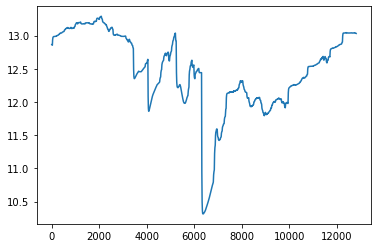

In [29]:
data[data['id'] == 0].R1.plot()

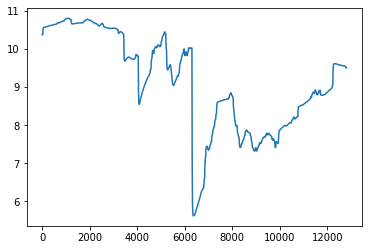

In [30]:
data[data['id'] == 0].R2.plot()

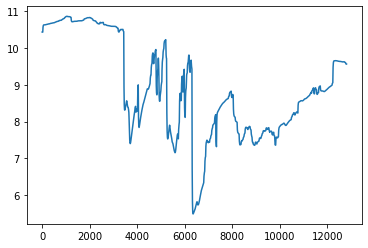

In [31]:
data[data['id'] == 0].R3.plot()

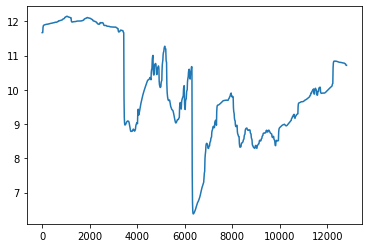

In [32]:
data[data['id'] == 0].R4.plot()

In [33]:
a = np.array([0, 1])
b = np.array([2, 3])
print(np.array([a, b]).T)

[[0 2]
 [1 3]]


In [34]:
def get_data(sample_size=50, cnt_signals=50):
    data_class1 = []
    data_class2 = []
    for i in range(sample_size):
        fst = data[data['id'] == i].R1
        sec = data[data['id'] == i].R2
        thd = data[data['id'] == i].R3
        fth = data[data['id'] == i].R4
        ffth = data[data['id'] == i].R5
        fst = fst[:30]
        sec = sec[:30]
        thd = thd[:30]
        fth = fth[:30]
        ffth = ffth[:30]
        #print(fst.shape, sec.shape, thd.shape, fth.shape)
        ts = np.array([fst, sec, thd, fth, ffth]).T
        #print(ts.shape)
        if data[data['id'] == i]['class'].iloc[0] == 'banana':
            data_class1.append(ts)
        else:
            data_class2.append(ts)
    return (np.array(data_class1), np.array(data_class2))

In [35]:
dim = 5

def experiment(data_class1, data_class2, sample_size=90, cnt_signals=30, dim=5):
    data = np.array(list(data_class1) + list(data_class2))
    labels = [0] * len(data_class1) + [1] * len(data_class2)
    exp = Experiment(data, labels)
    return exp.KNeighbourClassifier_test()

In [44]:
X = get_data()
cnt = 0
res = 0
res1 = 0
res2 = 0
#print(X[1].shape)

for i in range(15, min(len(X[0]), len(X[1]))):
    val_L2, val_DTW = experiment(X[0][:i], X[1][:i])
    cnt += 1
    if val_L2 < val_DTW:
        res += 1
    elif val_L2 == val_DTW:
        res1 += 1
    else:
        res2 += 1

[1 0 0 0 1 1 0 0 0]
[0 1 0 0 0 0 0 0 1]
0.6666666666666666 0.3333333333333333
[0 0 1 0 0 0 0 1 1 1]
[1 0 1 0 0 1 0 0 1 1]
0.6 0.5
[1 0 1 0 0 1 0 0 1 0 1]
[1 0 0 1 0 1 0 0 0 1 0]
0.09090909090909091 0.36363636363636365
[0 0 0 0 1 0 0 0 0 0 1]
[0 0 1 1 1 0 1 1 0 0 0]
0.45454545454545453 0.36363636363636365
[0 0 0 1 0 0 0 0 0 0 0 1]
[1 0 0 1 0 0 1 0 1 0 0 1]
0.4166666666666667 0.3333333333333333
[1 0 0 0 1 0 0 1 1 0 0 0]
[0 0 0 0 1 0 0 0 0 1 0 0]
0.6666666666666666 0.3333333333333333
[1 1 1 0 0 1 1 0 0 1 0 1 0]
[1 1 0 1 1 1 1 0 0 0 0 1 0]
0.5384615384615384 0.5384615384615384
[0 1 1 1 1 0 1 0 1 1 1 0 1 1]
[1 0 1 0 0 0 1 0 1 1 1 1 1 1]
0.5 0.5714285714285714
[0 1 1 1 0 1 1 0 1 1 0 0 0 0]
[0 1 1 0 0 1 1 0 1 1 0 1 0 1]
0.7142857142857143 0.5
